In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam


import keras_tuner as kt

import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, confusion_matrix, f1_score, classification_report, accuracy_score

from scipy.stats.mstats import winsorize

# Set seed untuk reproducibility
SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)


## Baca Datasetnya

In [2]:
df = pd.read_parquet("dataset_1A.parquet")

# EDA

In [3]:
df.head()

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption
0,8,3,Sunday,Yes,24.492063,59.969085,1403.454805,7,On,Off,29.965327,82.05735763545306
1,1,8,Wednesday,No,26.312114,51.408711,1220.547133,8,On,Off,5.986875,83.88917674427188
2,1,19,Sunday,Yes,20.516186,40.918500,1114.230124,8,Off,On,20.489098,66.20209750906106
3,7,3,Wednesday,Yes,20.879426,46.859237,1096.207227,7,Off,On,21.321157,66.43917871187017
4,10,17,Saturday,No,23.015216,48.998158,1999.982252,1,Off,Off,3.966075,76.90227179904673


Data ini sepertinya ingin memprediksi jumlah energi yang dikonsumsi sebuah building dengan **solar panel**, berdasarkan kondisi **lingkungan**, **operasional**, **waktu**, etc.

In [4]:
df.value_counts()

Month      Hour  DayOfWeek  Holiday  Temperature  Humidity   SquareFootage  Occupancy  HVACUsage  LightingUsage  RenewableEnergy  EnergyConsumption
1          0     Friday     Yes      24.015942    47.940536  1568.283340    3          Off        Off            14.993837        74.17904403679803    1
5          10    Thursday   Yes      27.062504    49.020519  1221.342108    5          On         On             15.930640        72.7420239983119     1
           11    Wednesday  No       20.007565    59.969085  1073.104210    1          Off        Off            0.006642         77.23821166052045    1
                 Tuesday    No       26.873046    58.935953  1558.573319    9          Off        Off            16.929317        62.25418411451488    1
                 Thursday   No       20.007565    53.381184  1999.982252    6          Off        On             0.006642         53.263278            1
                                                                                       

## Check Data Duplikat

In [5]:
df.duplicated().sum()

0

Tidak ada data yang duplikat

df.isnull().sum()

In [6]:
df[df.isnull().any(axis=1)]

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption


Hmmm, sejauh ini blm ada data yang hilang, tapi kita lihat terlebih dahulu tipe datanya sudah sesuai semua blm

In [7]:
df.shape

(1232, 12)

Terdapat 11 kolom independent, dan 1 kolom dependet yaitu energy yang dikonsumi

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1232 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1232 non-null   object 
 1   Hour               1232 non-null   int64  
 2   DayOfWeek          1232 non-null   object 
 3   Holiday            1232 non-null   object 
 4   Temperature        1232 non-null   float64
 5   Humidity           1232 non-null   float64
 6   SquareFootage      1232 non-null   float64
 7   Occupancy          1232 non-null   int64  
 8   HVACUsage          1232 non-null   object 
 9   LightingUsage      1232 non-null   object 
 10  RenewableEnergy    1232 non-null   float64
 11  EnergyConsumption  1232 non-null   object 
dtypes: float64(4), int64(2), object(6)
memory usage: 115.6+ KB


Nah, sekarang terlihat ada masalah pada Energi Consumtion dan Month, mengapa ada object yang seharusnya float dan int

In [9]:
# Cek nilai yang mengandung huruf
invalid_values = [val for val in df['EnergyConsumption'].dropna().unique() if re.search(r'[a-zA-Z]', str(val))]

print(" Nilai mencurigakan yang mengandung huruf:")
print(invalid_values)

for val in invalid_values:
    count = (df['EnergyConsumption'] == val).sum()
    print(f" '{val}' muncul sebanyak {count} kali")

 Nilai mencurigakan yang mengandung huruf:
['nan']
 'nan' muncul sebanyak 3 kali


Ternyata ada string "nan" yang muncul 3x sehingga merusak tipe data

In [10]:
df['EnergyConsumption'] = pd.to_numeric(df['EnergyConsumption'], errors='coerce')

In [11]:
df = df.dropna()

Karena hanya 3 data maka aku akan melakukan drop data ini

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1229 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1229 non-null   object 
 1   Hour               1229 non-null   int64  
 2   DayOfWeek          1229 non-null   object 
 3   Holiday            1229 non-null   object 
 4   Temperature        1229 non-null   float64
 5   Humidity           1229 non-null   float64
 6   SquareFootage      1229 non-null   float64
 7   Occupancy          1229 non-null   int64  
 8   HVACUsage          1229 non-null   object 
 9   LightingUsage      1229 non-null   object 
 10  RenewableEnergy    1229 non-null   float64
 11  EnergyConsumption  1229 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 124.8+ KB


### Mari kita lihat keseluruhan data jika ada anomali, kita akan coba benarkan

In [13]:
unique_values_dict = {}

for column in df.columns:
    unique_values_dict[column] = list(df[column].unique())

# Mencetak setiap list nilai unik dengan tiga baris kosong di antaranya
for column, values in unique_values_dict.items():
    print(f"Unique values in '{column}': {values}")
    print("\n" * 3)  # Menambahkan tiga baris kosong

Unique values in 'Month': ['8', '1', '7', '10', '4', '2', '5', '6', '11', '9', '12', '3', 'Sep', 'July', 'September']




Unique values in 'Hour': [3, 8, 19, 17, 0, 9, 7, 20, 13, 21, 6, 2, 23, 16, 14, 12, 10, 5, 11, 15, 22, 18, 1, 4]




Unique values in 'DayOfWeek': ['Sunday', 'Wednesday', 'Saturday', 'Friday', 'Tuesday', 'Monday', 'Thursday']




Unique values in 'Holiday': ['Yes', 'No']




Unique values in 'Temperature': [24.492063368523866, 26.312113992801667, 20.51618553995076, 20.87942639874524, 23.0152157359686, 29.998671, 22.264566775822413, 25.30676096403999, 20.007565, 29.89411205743434, 21.26410298335915, 23.10481919400513, 26.455075484773086, 23.908724537929206, 22.242008125293754, 24.481603453425432, 27.625083013478267, 28.816258160012165, 24.30523476134897, 28.1761003941524, 29.76325035844921, 21.13141310835403, 28.20128396671334, 23.14771395969388, 26.74814311381064, 20.044430031226053, 24.00154527976945, 26.800996699435117, 25.480164067044672, 24.00783052077012, 28.542

Setelah kucermati ternyata ada beberapa anomali pada data misalnya **occupancy** yang tidak mungkin minus, dan ada inkonsisten penulisan data seperti *"Sep"*, *"July"*, *September*, semuanya akan coba kubenarkan

In [14]:
df['Month'] = df['Month'].replace({
    'Sep': '9',
    'July': '7',
    'September': '9'
})
df['Month'] = df['Month'].astype(int)

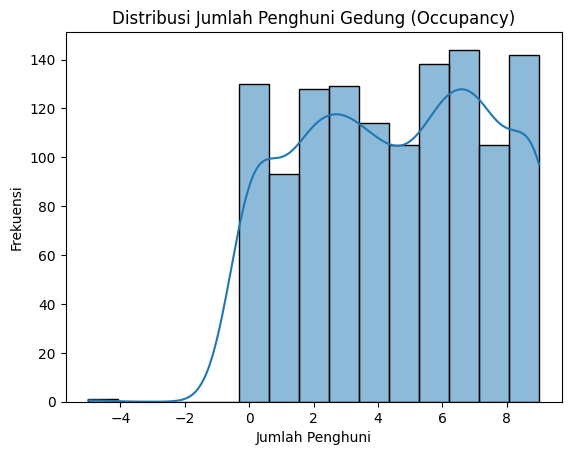

In [15]:
sns.histplot(df['Occupancy'], kde=True)
plt.title("Distribusi Jumlah Penghuni Gedung (Occupancy)")
plt.xlabel("Jumlah Penghuni")
plt.ylabel("Frekuensi")
plt.show()

Karena distribusinya cukup normal, aku akan mencoba mengubah semua nilai minus menjadi mean

In [16]:
mean_val = round(df.loc[df['Occupancy'] >= 0, 'Occupancy'].mean())
df.loc[df['Occupancy'] < 0, 'Occupancy'] = mean_val


# Cek ulang apakah masih ada nilai negatif
df[df['Occupancy'] < 0]

,Month,Hour,DayOfWeek,Holiday,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,EnergyConsumption


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1229 entries, 0 to 1231
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1229 non-null   int32  
 1   Hour               1229 non-null   int64  
 2   DayOfWeek          1229 non-null   object 
 3   Holiday            1229 non-null   object 
 4   Temperature        1229 non-null   float64
 5   Humidity           1229 non-null   float64
 6   SquareFootage      1229 non-null   float64
 7   Occupancy          1229 non-null   int64  
 8   HVACUsage          1229 non-null   object 
 9   LightingUsage      1229 non-null   object 
 10  RenewableEnergy    1229 non-null   float64
 11  EnergyConsumption  1229 non-null   float64
dtypes: float64(5), int32(1), int64(2), object(4)
memory usage: 120.0+ KB


## Mengurutkan data bulanan dan mingguan supaya gampang diencode

In [18]:
print("Unique values in 'Month':", sorted(df['Month'].unique()))

Unique values in 'Month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [19]:
print("Unique values in 'Day':", (df['DayOfWeek'].unique()))

Unique values in 'Day': ['Sunday' 'Wednesday' 'Saturday' 'Friday' 'Tuesday' 'Monday' 'Thursday']


## Liat distribusi data

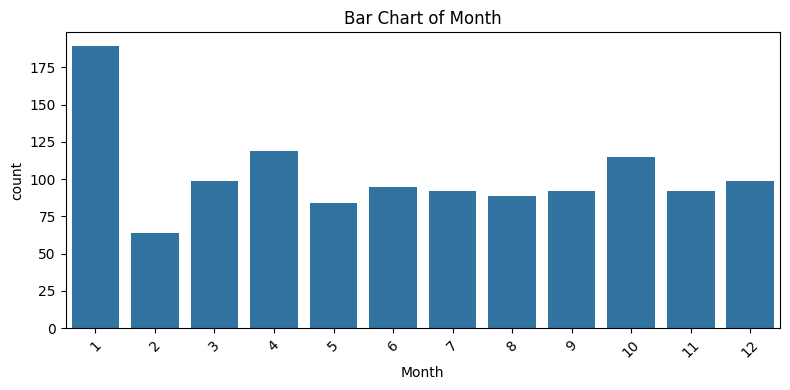

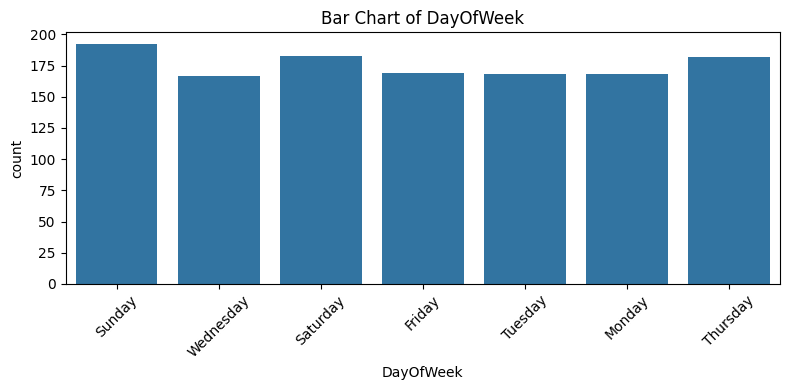

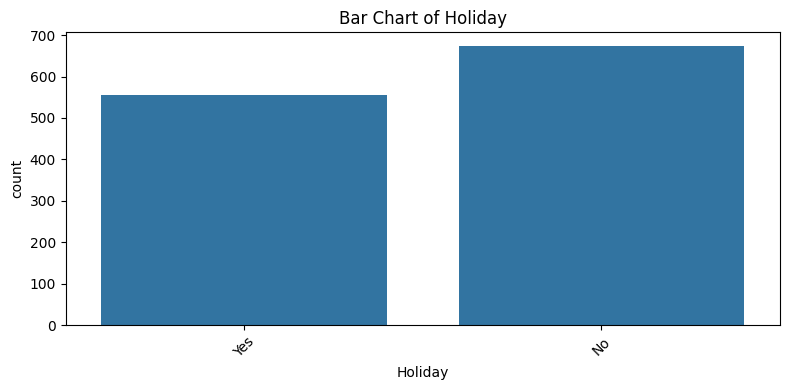

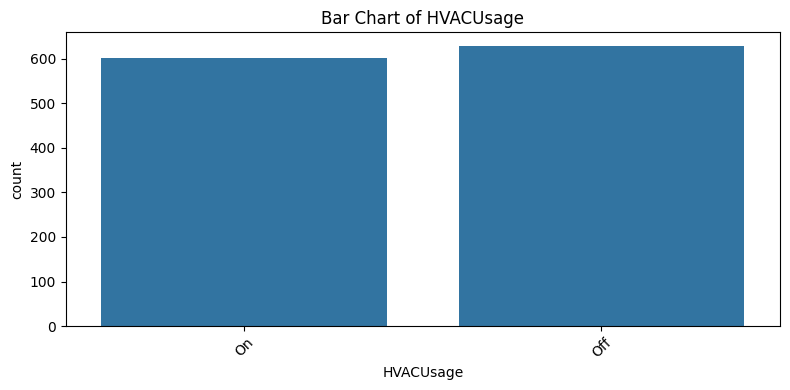

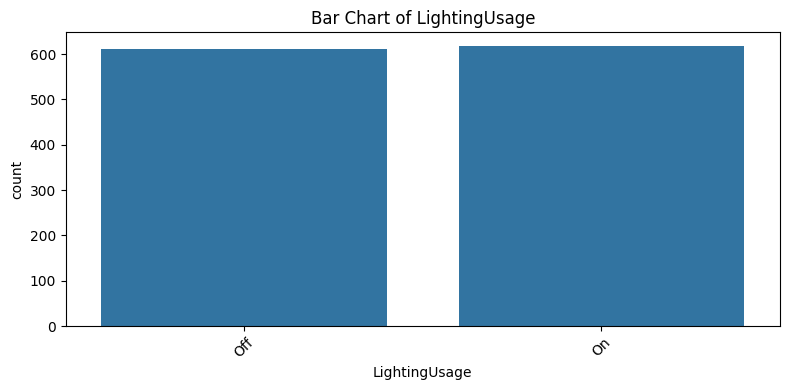

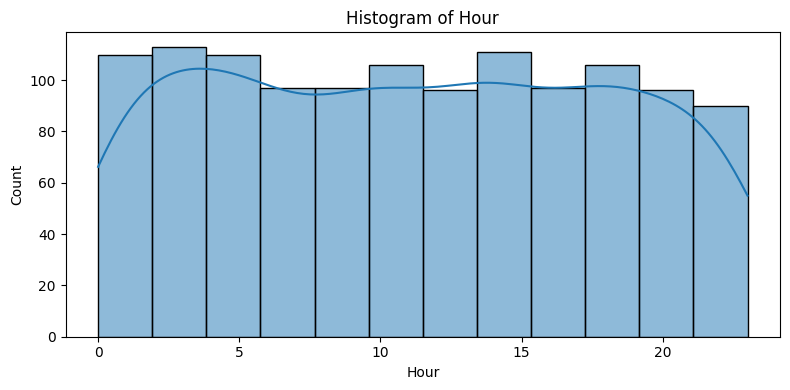

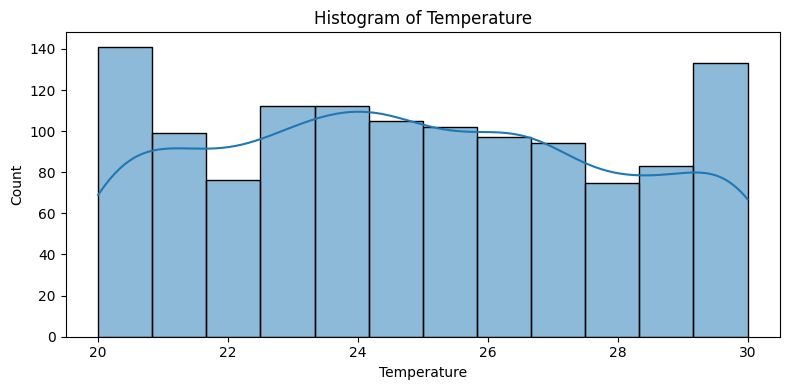

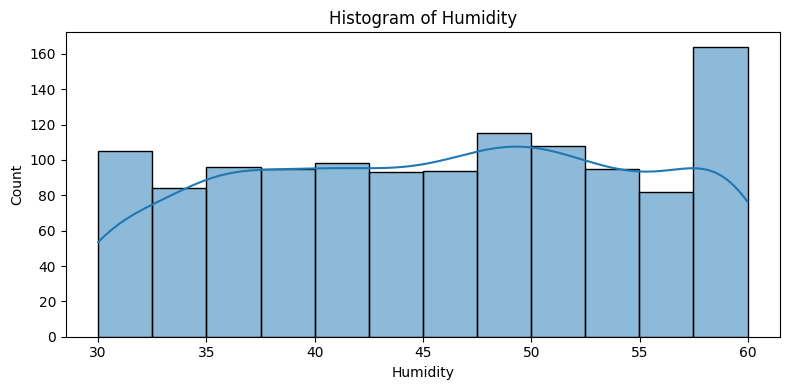

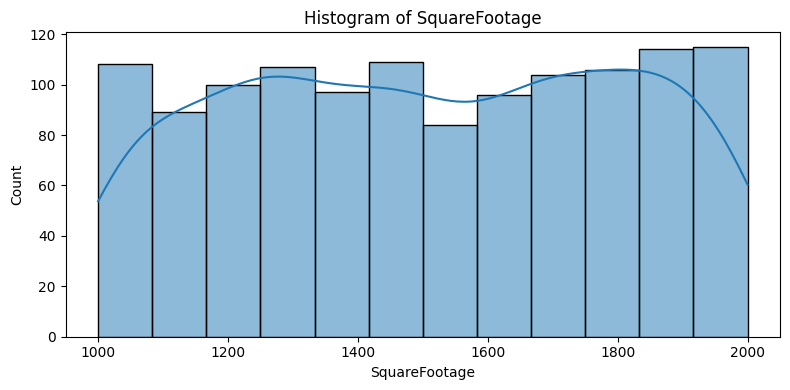

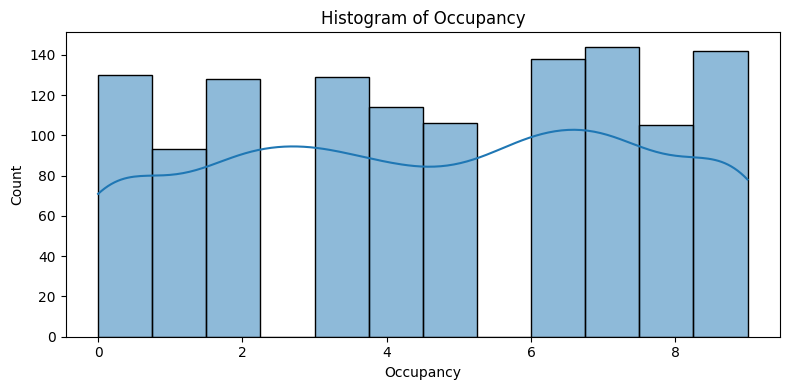

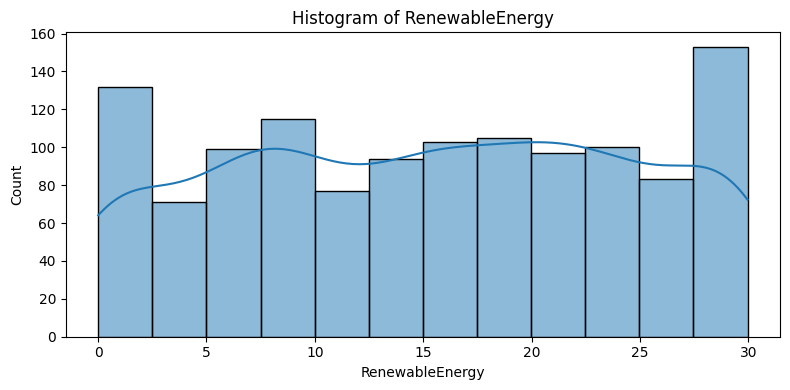

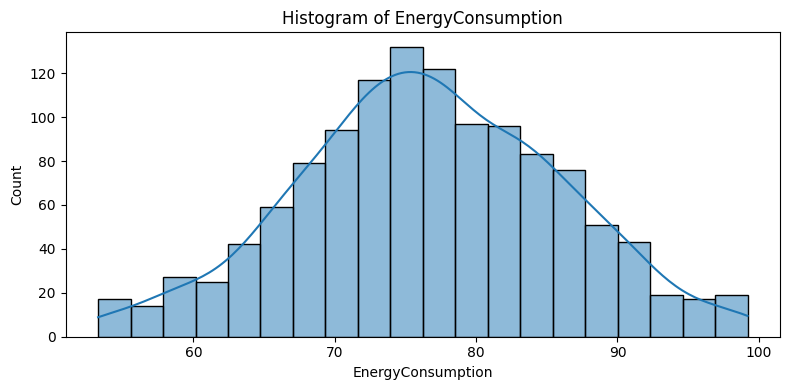

In [20]:
# Define categorical and numerical columns
categorical_cols = ['Month', 'DayOfWeek', 'Holiday', 'HVACUsage', 'LightingUsage']
numerical_cols = ['Hour', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy', 'EnergyConsumption']

# Plot bar charts for categorical columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Bar Chart of {col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot histograms for numerical columns
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Histogram of {col}')
    plt.tight_layout()
    plt.show()


Mayoritas data sudah berdistribusi merata dengan pengecualian **month** dan **holiday** yang sedikit miring

## Feature Encoding

In [21]:
# 1. Encode kolom biner (Yes/No dan On/Off) menjadi 0/1
binary_map = {'Yes': 1, 'No': 0, 'On': 1, 'Off': 0}
df['Holiday'] = df['Holiday'].map(binary_map)
df['HVACUsage'] = df['HVACUsage'].map(binary_map)
df['LightingUsage'] = df['LightingUsage'].map(binary_map)

Kolom yang hanya memiliki 2 unique kategori cocok untuk diencode secara binary

In [22]:
# 2. One-Hot Encoding untuk kolom DayOfWeek
df = pd.get_dummies(df, columns=['DayOfWeek'], prefix='Day')

Karena terdapat lebih dari dua kategori, saya melakukan one-hot encoding agar tidak ada prioritas atau urutan antar label dalam perhitungan model.

In [23]:
# 3. Sine dan Cosine encoding untuk data waktu musiman
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

Untuk kedua unit waktu ini aku menggunakan sine dan cosine encoding untuk mereprsentasikan waktu dalam bentuk koordinat pada lingkaran untuk membantu model ann mengenali pola musiman dan harian

In [24]:
print("Kolom setelah encoding:")
print(df.columns.tolist())

Kolom setelah encoding:
['Month', 'Hour', 'Holiday', 'Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'HVACUsage', 'LightingUsage', 'RenewableEnergy', 'EnergyConsumption', 'Day_Friday', 'Day_Monday', 'Day_Saturday', 'Day_Sunday', 'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos']


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1229 entries, 0 to 1231
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Month              1229 non-null   int32  
 1   Hour               1229 non-null   int64  
 2   Holiday            1229 non-null   int64  
 3   Temperature        1229 non-null   float64
 4   Humidity           1229 non-null   float64
 5   SquareFootage      1229 non-null   float64
 6   Occupancy          1229 non-null   int64  
 7   HVACUsage          1229 non-null   int64  
 8   LightingUsage      1229 non-null   int64  
 9   RenewableEnergy    1229 non-null   float64
 10  EnergyConsumption  1229 non-null   float64
 11  Day_Friday         1229 non-null   bool   
 12  Day_Monday         1229 non-null   bool   
 13  Day_Saturday       1229 non-null   bool   
 14  Day_Sunday         1229 non-null   bool   
 15  Day_Thursday       1229 non-null   bool   
 16  Day_Tuesday        1229 non-n

## Heatmap dan Spearman Correlation Map untuk feature encoding

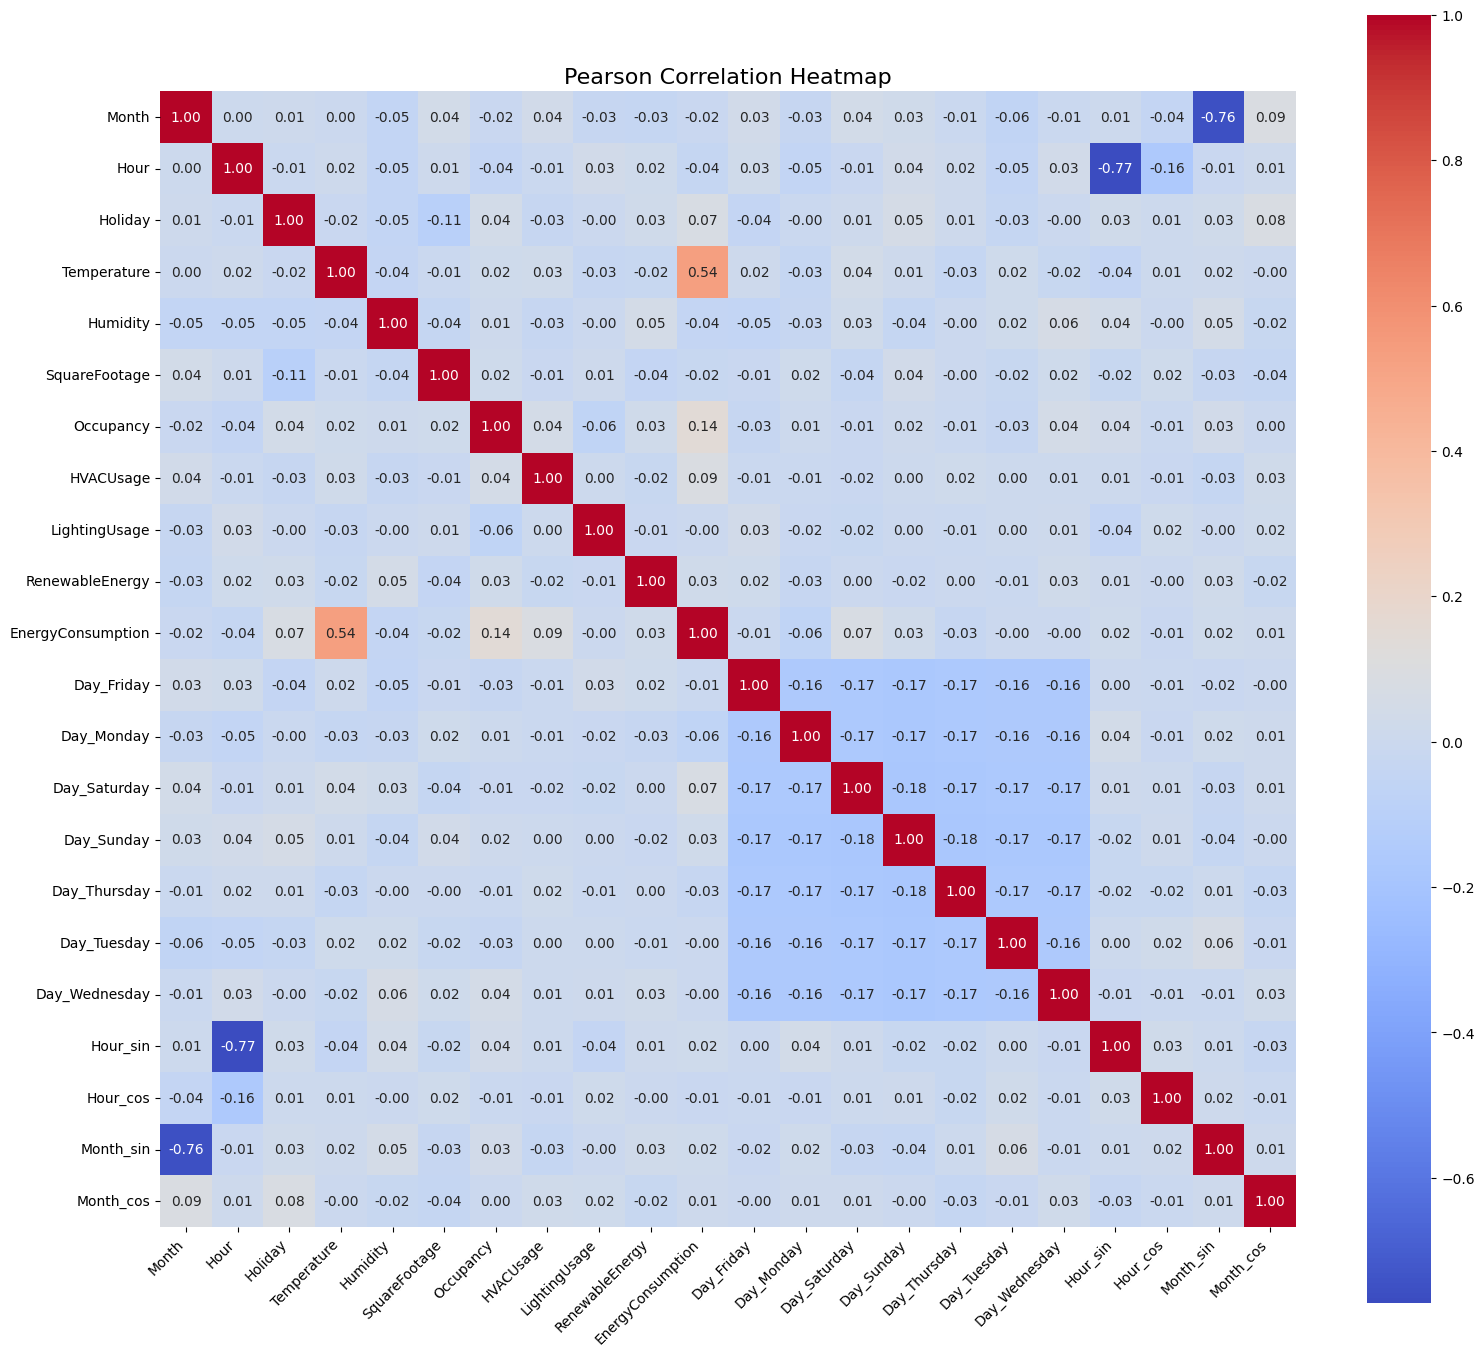

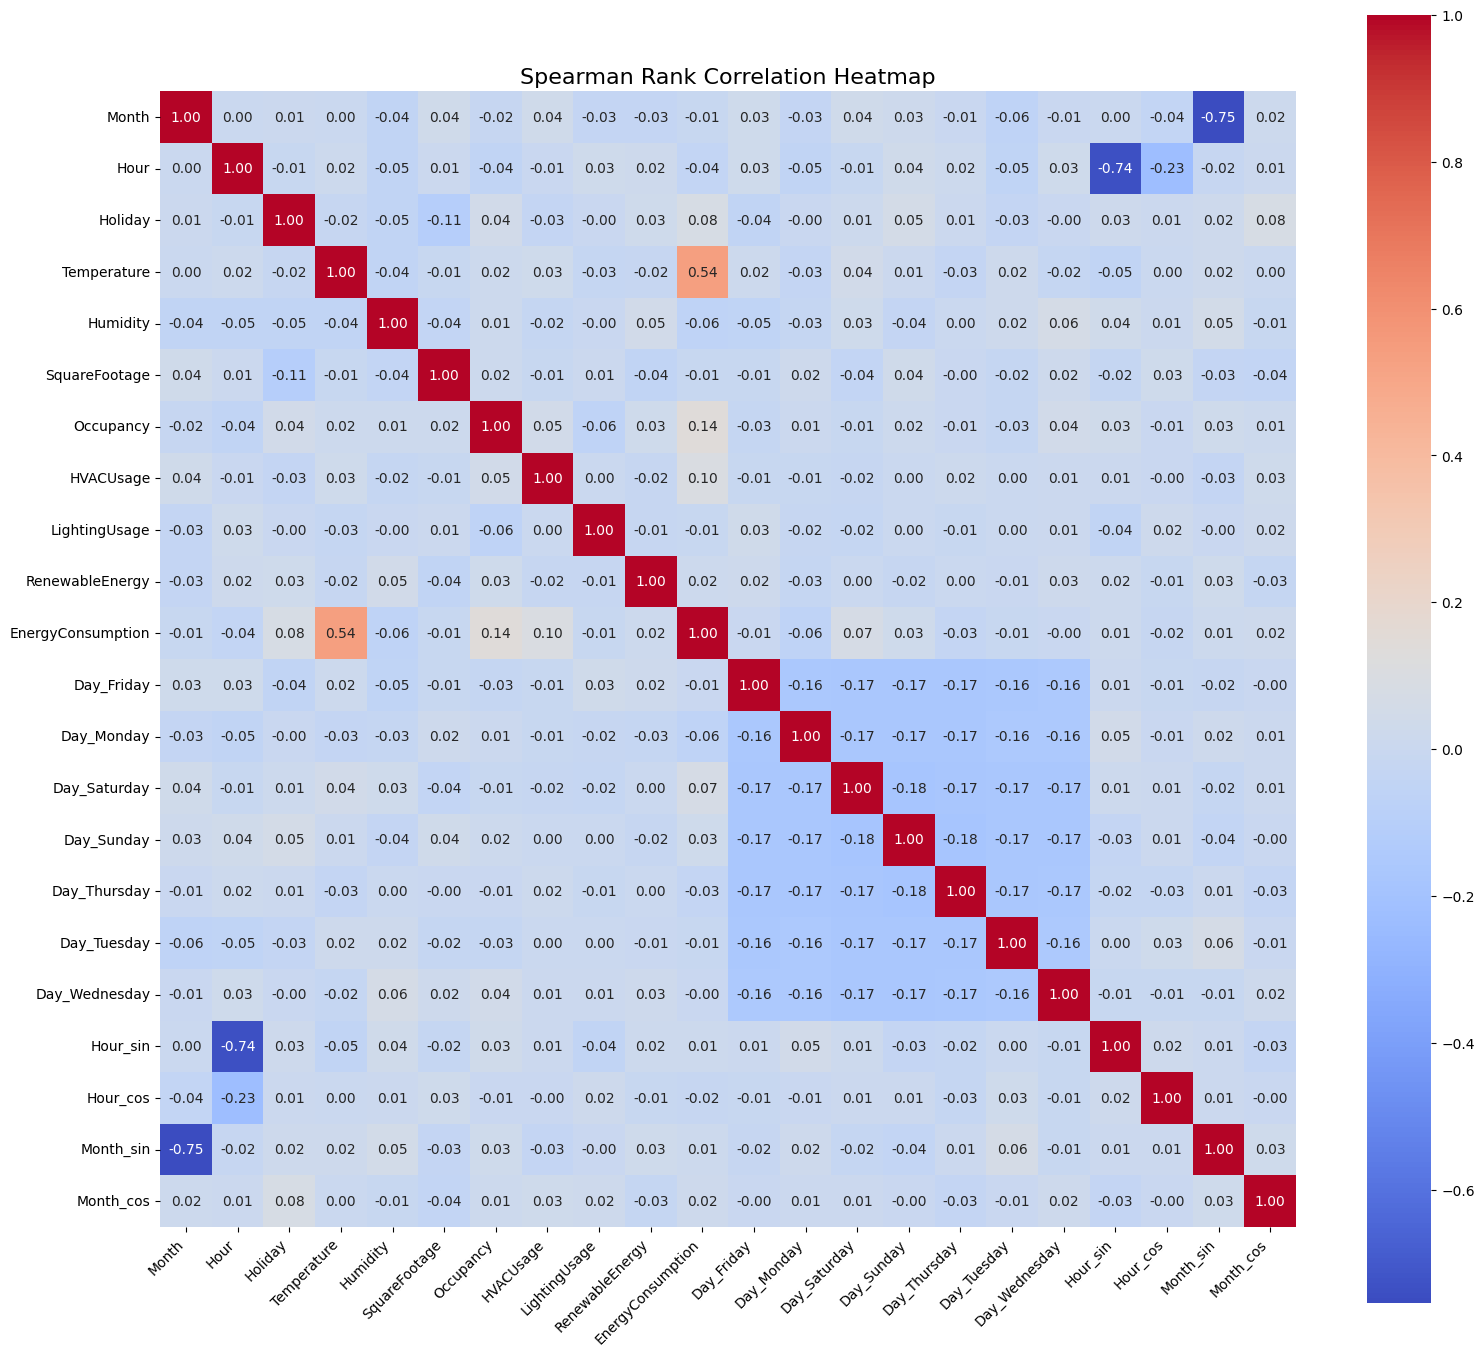

In [26]:
def plot_corr_heatmap(df, method='pearson', title='Correlation Heatmap'):
    plt.figure(figsize=(16, 14))  # Ukuran besar agar label tidak saling tumpuk
    sns.heatmap(df.corr(method=method), annot=True, fmt=".2f", cmap='coolwarm', square=True)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Pearson
plot_corr_heatmap(df, method='pearson', title='Pearson Correlation Heatmap')

# Spearman
plot_corr_heatmap(df, method='spearman', title='Spearman Rank Correlation Heatmap')



Waduh, sepertinya datanya banyak yang korelasinya sangat rendah, supaya tetap beberapa dapat terpilih aku tetap menggunakan threshold 0.05, normalnya seharnya bisa lebih besar

In [27]:
def select_correlated_features(df, target_col='EnergyConsumption', method='spearman', threshold=0.05):
    """
    Mengembalikan fitur-fitur yang korelasinya (abs) dengan target >= threshold.
    
    Parameters:
        df: DataFrame input
        target_col: nama kolom target
        method: jenis korelasi ('pearson', 'spearman', 'kendall')
        threshold: ambang korelasi absolut
        
    Returns:
        List of selected feature names
    """
    corr = df.corr(method=method)[target_col]
    selected_features = corr[abs(corr) >= threshold].index.tolist()
    if target_col in selected_features:
        selected_features.remove(target_col)
    return selected_features


In [28]:
selected_spearman = select_correlated_features(df, method='spearman', threshold=0.05)
selected_kendall = select_correlated_features(df, method='kendall', threshold=0.05)
selected_pearson = select_correlated_features(df, method='pearson', threshold=0.05)

print("📌 Spearman:", selected_spearman)
print("📌 Pearson :", selected_pearson)


📌 Spearman: ['Holiday', 'Temperature', 'Humidity', 'Occupancy', 'HVACUsage', 'Day_Monday', 'Day_Saturday']
📌 Pearson : ['Holiday', 'Temperature', 'Occupancy', 'HVACUsage', 'Day_Monday', 'Day_Saturday']


In [29]:
# Fitur terpilih berdasarkan korelasi
selected_features = ['Holiday', 'Temperature', 'Humidity', 'Occupancy', 'HVACUsage', 'Day_Monday', 'Day_Saturday']
X = df[selected_features]
y = df['EnergyConsumption']

In [30]:
# Split: Train (70%) dan Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# Split Val (10%) dan Test (20%) → Val = 10/30 = 1/3 dari Temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=42)

In [32]:
# Ubah tipe data ke float32 agar TensorFlow tidak error
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

In [33]:
# Tampilkan proporsi data
len(X_train), len(X_val), len(X_test)

(860, 123, 246)

Jumlah train test dan val

### Set Batch Size = 32

In [34]:
# TF Dataset
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(32)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

Mengonversi data menjadi dataset TensorFlow, lalu membagi dataset menjadi batch berisi 32 sampel untuk efisiensi pelatihan dan Mmngacak data dalam buffer berisi 100 sampel untuk mencegah pola tertentu dalam pelatihan.


# b

## Sequential Model Preparation

In [35]:
# Baseline Sequential Model
input_dim = X_train.shape[1]
hidden_neurons = input_dim * 2  # 2x jumlah input diminta di soal
# 1. Baseline Sequential Model
seq_model = Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(hidden_neurons, activation='relu'), #activation function ReLu diminta soal
    layers.Dense(hidden_neurons, activation='relu'), #activation function ReLu diminta soal
    layers.Dense(1) # output layer regression
])
seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                112       
                                                                 
 dense_1 (Dense)             (None, 14)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 15        
                                                                 
Total params: 337
Trainable params: 337
Non-trainable params: 0
_________________________________________________________________


## Functional Model Preparation

In [36]:
# 2. Baseline Functional Model (dengan skip connection)
input_layer = Input(shape=(input_dim,))
x1 = layers.Dense(hidden_neurons, activation='relu')(input_layer)
x2 = layers.Dense(hidden_neurons, activation='relu')(x1)
skip = layers.Concatenate()([input_layer, x2])  # skip connection
output = layers.Dense(1)(skip)
func_model = Model(inputs=input_layer, outputs=output)

Di fucntional modelnya aku coba tambahkan skip connection yang tidak bisa dilakukan di sequential model yang beralur linear/ maju terus, dengan menggunakan skip connection, memungkinakan kita untuk menghubngkan input langsung ke layer akhir, membantu model menjaga informasi awal dan tentunya mengurasi resiko masalah vanishing gradient yang merupakan masalah klasik pada ANN

### Set optimizer and Loss Function untuk Model ANN Regression

In [37]:
# Kompilasi
for model in [seq_model, func_model]:
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

- Optimizer yang dipilih adalah Adam, karena kemampuannya yang secara dinamis mengubah nilai learning rate dalam mencari global minimum, serta menggabungkan keunggulan momentum (SGD) dan RMSProp untuk konvergensi yang lebih cepat dan stabil.
- Loss function yang digunakan adalah Mean Squared Error (MSE), karena ini merupakan fungsi kerugian yang umum digunakan untuk masalah regresi dan sensitif terhadap error besar.

## Callback Function

In [38]:
# Callback EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Callback Early Stopping aku gunakan untuk menghentikan pelatihan jika tidak ada perbaikan pada val_loss selama 5 epoch berturut-turut. Selain itu, restore_best_weights=True memastikan model akan kembali ke bobot terbaik dari epoch dengan val_loss terendah.

### Sequential dan Functional Model Train (5000 epoch dengan earlystopping)

In [39]:
history_seq = seq_model.fit(X_train, y_train,
                            validation_data=(X_val, y_val),
                            epochs=5000, batch_size=32, callbacks=[early_stop],
                            verbose=2)

history_func = func_model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              epochs=5000, batch_size=32, callbacks=[early_stop],
                              verbose=2)

Epoch 1/5000
27/27 - 2s - loss: 7181.3501 - mae: 84.1522 - val_loss: 6093.8516 - val_mae: 77.5376 - 2s/epoch - 67ms/step
Epoch 2/5000
27/27 - 0s - loss: 5445.4351 - mae: 73.1441 - val_loss: 4447.1387 - val_mae: 66.0557 - 124ms/epoch - 5ms/step
Epoch 3/5000
27/27 - 0s - loss: 3861.8601 - mae: 61.2471 - val_loss: 2972.6233 - val_mae: 53.6082 - 127ms/epoch - 5ms/step
Epoch 4/5000
27/27 - 0s - loss: 2498.9333 - mae: 48.7640 - val_loss: 1760.5529 - val_mae: 40.5064 - 125ms/epoch - 5ms/step
Epoch 5/5000
27/27 - 0s - loss: 1410.2814 - mae: 35.6391 - val_loss: 853.8214 - val_mae: 26.8367 - 115ms/epoch - 4ms/step
Epoch 6/5000
27/27 - 0s - loss: 624.9843 - mae: 22.0865 - val_loss: 328.0631 - val_mae: 14.9038 - 126ms/epoch - 5ms/step
Epoch 7/5000
27/27 - 0s - loss: 257.9062 - mae: 13.0095 - val_loss: 185.9539 - val_mae: 10.9726 - 128ms/epoch - 5ms/step
Epoch 8/5000
27/27 - 0s - loss: 173.9098 - mae: 10.8022 - val_loss: 173.1225 - val_mae: 10.8807 - 137ms/epoch - 5ms/step
Epoch 9/5000
27/27 - 0s -

## Evaluation Metric

In [40]:
y_test = y_test.astype('float32')

# Prediksi
y_pred_seq = seq_model.predict(X_test).flatten()
y_pred_func = func_model.predict(X_test).flatten()

# Evaluasi fungsi
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n Evaluation: {model_name}")
    print(f"MAE   : {mae:.4f}")
    print(f"MSE   : {mse:.4f}")
    print(f"RMSE  : {rmse:.4f}")
    print(f"R²    : {r2:.4f}")

evaluate_model(y_test, y_pred_seq, 'Baseline Sequential ANN')
evaluate_model(y_test, y_pred_func, 'Baseline Functional ANN (Skip Connection)')

8/8 [==============================] - 0s 2ms/step

 Evaluation: Baseline Sequential ANN
MAE   : 6.2234
MSE   : 65.8780
RMSE  : 8.1165
R²    : 0.2024

 Evaluation: Baseline Functional ANN (Skip Connection)
MAE   : 6.2388
MSE   : 66.7848
RMSE  : 8.1722
R²    : 0.1915


**Model Sequential** menunjukkan performa yang **sedikit lebih baik** dibanding Functional Model dengan MAE dan RMSE lebih rendah sehingga kesalahan prediksi lebih kecil. R² score  juga lebih tinggi sehingga mampu menjelaskan variasi target dengan lebih baik. Sedangkan untuk **Model Functional dengan Skip Connection** blm memberikan peningkatan performa. Jadi, Untuk model baseline justru lebih baik sequential.

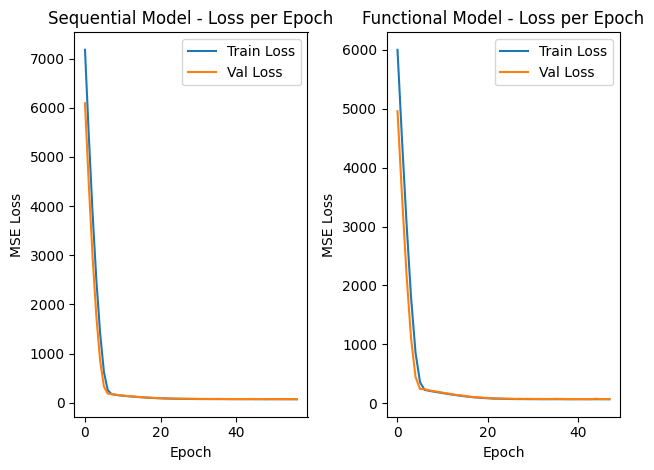

In [41]:
# Sequential Model Loss
plt.subplot(1, 2, 1)
plt.plot(history_seq.history['loss'], label='Train Loss')
plt.plot(history_seq.history['val_loss'], label='Val Loss')
plt.title('Sequential Model - Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Functional Model Loss
plt.subplot(1, 2, 2)
plt.plot(history_func.history['loss'], label='Train Loss')
plt.plot(history_func.history['val_loss'], label='Val Loss')
plt.title('Functional Model - Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.show()

Kedua model berhasil menurunkan MSE Loss dengan cukup baik dan cepat tanpa terlihat pola overfitting, tetapi tetap Validation loss terlihat sedikit lebih tinggi daripada Sequential, terutama di akhir epoch memperlihatkan tetap lebih baik dequential model dalam kasus ini.

In [42]:
# Buat prediksi pada validation set
y_pred_val = seq_model.predict(X_val).flatten()

# Tampilkan beberapa nilai prediksi dan aktualnya
val_results = pd.DataFrame({
    'y_actual': y_val.values,
    'y_pred': y_pred_val
})

print(val_results.head(10))

4/4 [==============================] - 0s 2ms/step
    y_actual     y_pred
0  82.673157  82.443176
1  71.732559  84.457848
2  75.028397  89.983116
3  83.589256  71.550903
4  76.961197  72.612389
5  73.793999  78.742554
6  74.153183  70.000130
7  53.263279  64.391258
8  87.780991  82.158577
9  74.576805  73.017921


In [43]:
# Buat prediksi pada validation set
y_pred_val = func_model.predict(X_val).flatten()

# Tampilkan beberapa nilai prediksi dan aktualnya
val_results = pd.DataFrame({
    'y_actual': y_val.values,
    'y_pred': y_pred_val
})

print(val_results.head(10))

4/4 [==============================] - 0s 4ms/step
    y_actual     y_pred
0  82.673157  81.400429
1  71.732559  84.471970
2  75.028397  88.852509
3  83.589256  71.976395
4  76.961197  74.115616
5  73.793999  79.036697
6  74.153183  68.799095
7  53.263279  62.721436
8  87.780991  81.961113
9  74.576805  73.588066


Hasil prediksi kedua model, errornya juga tidak terlalu besar

# C

# Modified Sequential Model

- Jumlah hidden layer bertambah dari 2 menjadi 3.
- Jumlah neuron diperbesar dari baseline (3×, 2×, dan 1× input dimensi).

In [44]:
mod_seq_model = Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(input_dim * 3, activation='relu'),
    layers.Dense(input_dim * 2, activation='relu'),
    layers.Dense(input_dim, activation='relu'),
    layers.Dense(1)
])

# Modified Functional Model (Skip Connection)

- Jumlah hidden layer bertambah  dari 2 jadi 3 hidden layers
- Jumlah neuron meningkat: dari 2× input_dim menjadi 4×, 2×, lalu 1x
- Skip connection diperluas: dilakukan antara dua hidden layers (x1 dan x2), bukan dari input langsung ke hidden layer seperti sebelumnya

In [45]:
input_mod = Input(shape=(input_dim,))
x1 = layers.Dense(input_dim * 4, activation='relu')(input_mod)
x2 = layers.Dense(input_dim * 2, activation='relu')(x1)
x3 = layers.Concatenate()([x1, x2])  # skip connection
x4 = layers.Dense(input_dim, activation='relu')(x3)
output_mod = layers.Dense(1)(x4)

mod_func_model = Model(inputs=input_mod, outputs=output_mod)

# Compile & Training dengan Hyperparameter Tuning
- Optimizer: Adam dengan learning_rate=0.0005 # Learning ratenya dicoba diturunkan untuk memberikan pelatihan yang lebih halus dan stabil
- Epochs: 5000
- EarlyStopping untuk menghindari overfitting # supaya cepet aja, kalau tidak ada update langsung disudahi trainingnya:)

In [ ]:
for model in [mod_seq_model, mod_func_model]:
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history_mod_seq = mod_seq_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                    epochs=5000, batch_size=32, callbacks=[early_stop], verbose=2)

history_mod_func = mod_func_model.fit(X_train, y_train, validation_data=(X_val, y_val),
                                      epochs=5000, batch_size=32, callbacks=[early_stop], verbose=2)


Epoch 1/5000
27/27 - 1s - loss: 6490.2021 - mae: 79.9779 - val_loss: 6118.0508 - val_mae: 77.6574 - 530ms/epoch - 20ms/step
Epoch 2/5000
27/27 - 0s - loss: 6139.8208 - mae: 77.7762 - val_loss: 5866.0132 - val_mae: 76.0278 - 169ms/epoch - 6ms/step
Epoch 3/5000
27/27 - 0s - loss: 5990.4888 - mae: 76.8194 - val_loss: 5815.3760 - val_mae: 75.6964 - 158ms/epoch - 6ms/step
Epoch 4/5000
27/27 - 0s - loss: 5947.0469 - mae: 76.5379 - val_loss: 5768.7075 - val_mae: 75.3883 - 154ms/epoch - 6ms/step
Epoch 5/5000
27/27 - 0s - loss: 5881.5688 - mae: 76.1105 - val_loss: 5678.6484 - val_mae: 74.7916 - 149ms/epoch - 6ms/step
Epoch 6/5000
27/27 - 0s - loss: 5750.5317 - mae: 75.2489 - val_loss: 5495.9585 - val_mae: 73.5641 - 164ms/epoch - 6ms/step
Epoch 7/5000
27/27 - 0s - loss: 5513.3560 - mae: 73.6577 - val_loss: 5196.7104 - val_mae: 71.5067 - 158ms/epoch - 6ms/step
Epoch 8/5000
27/27 - 0s - loss: 5149.2109 - mae: 71.1488 - val_loss: 4762.8379 - val_mae: 68.4115 - 167ms/epoch - 6ms/step
Epoch 9/5000
27

## Visualisasi Loss Curve

In [ ]:
plt.figure(figsize=(12, 5))

# Sequential Mod
plt.subplot(1, 2, 1)
plt.plot(history_mod_seq.history['loss'], label='Train Loss')
plt.plot(history_mod_seq.history['val_loss'], label='Val Loss')
plt.title('Modified Sequential - Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Functional Mod
plt.subplot(1, 2, 2)
plt.plot(history_mod_func.history['loss'], label='Train Loss')
plt.plot(history_mod_func.history['val_loss'], label='Val Loss')
plt.title('Modified Functional - Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.tight_layout()
plt.show()


Kedua model yang sudah dimodifikasi ini juga berhasil menurunkan MSE Loss dengan cukup baik dan cepat tanpa terlihat pola overfitting, tetapi tetap Validation loss terlihat sedikit lebih tinggi daripada Sequential, terutama di akhir epoch memperlihatkan tetap lebih baik dequential model dalam kasus ini.

# d

In [ ]:
def evaluate_models(model_dict, X_test, y_test):
    results = []
    for name, model in model_dict.items():
        y_pred = model.predict(X_test).flatten()
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)
        results.append({
            'Model': name,
            'MAE': round(mae, 4),
            'RMSE': round(rmse, 4),
            'R²': round(r2, 4)
        })
    return pd.DataFrame(results).sort_values(by='RMSE')

model_dict = {
    'Baseline Sequential': seq_model,
    'Baseline Functional': func_model,
    'Modified Sequential': mod_seq_model,
    'Modified Functional': mod_func_model
}

eval_df = evaluate_models(model_dict, X_test, y_test)
print(eval_df)


Ternyata, modifikasi arsitektur tidak selalu menjamin peningkatan performa. Dalam eksperimen ini, Baseline Sequential ANN justru menghasilkan performa terbaik dibanding ketiga model lainnya. Dengan MAE terendah (6.2234), RMSE terendah (8.1165), dan nilai R² tertinggi (0.2024), model ini menunjukkan bahwa konfigurasi sederhana dengan dua hidden layer, jumlah neuron minimal 2× jumlah fitur, serta aktivasi ReLU sudah cukup efektif untuk menangkap pola dalam dataset ini.

Sementara itu, baik Baseline Functional ANN maupun Modified Functional hanya memberikan sedikit peningkatan atau bahkan penurunan performa. Terlebih lagi, Modified Sequential ANN menunjukkan hasil paling buruk, dengan penurunan signifikan pada nilai R² (hanya 0.0671). Ini mengindikasikan bahwa penambahan jumlah layer dan neuron tanpa strategi regularisasi atau tuning yang optimal justru memperbesar risiko overfitting, apalagi pada dataset yang relatif kecil seperti ini.

# Notes: seharusnya aku bisa hypertune lebih, tapi karena time constraint jadi tidak sempat pak, kami baru saja dihajar oleh ADA dan OS pak:)

# e

Video analisa: https://drive.google.com/drive/folders/1cWJSmxjQZ97FmZC5Ou-swHd6oagH755h?usp=sharing